# Homework 4

In [16]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

C:\Users\Avshugan\AppData\Local\Temp\ipykernel_21184\2344506368.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображенииа, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершут предобработку картинки, писанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер равномерно занимало место, то есть если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в приложении к этому занятию.

<table><tr>
    <td> <img src="https://i.ibb.co/fkScTsg/test_image_01.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/q7PQRtZ/test_image_03.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/StTqhST/test_image_08.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [17]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    out = image.copy()
    
    z = np.zeros([pad_height, out.shape[1]])
    out = np.r_[z.copy(), out, z.copy()]

    z = np.zeros([out.shape[0], pad_width])
    out = np.c_[z.copy(), out, z.copy()]
    return out


In [18]:
def conv_faster(image, kernel):
    """
    :param image: изображение 
    :param kernel: ядро
    :return: свертка
    """
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    
    im = zero_pad(image, Hk // 2, Wk//2)
    
    Hi, Wi = im.shape
    kern = np.r_[kernel, np.zeros([Hi-Hk, Wk])]
    kern = np.c_[kern, np.zeros([kern.shape[0] ,Wi-Wk])]

    fim = np.fft.fft2(im)  
    fim = np.fft.fftshift(fim) 
    fkern = np.fft.fft2(kern)  
    fkern = np.fft.fftshift(fkern)  
    
    fout = fim*fkern
     
    out = np.fft.ifftshift(fout)  
    out = np.fft.ifft2(out)
    out = np.real(out)
    
    out = np.delete(out, range(Wk-kernel.shape[1]%2), 1)  
    out = np.delete(out, range(Hk-kernel.shape[0]%2), 0)
    
    return out.astype(np.int64)

In [19]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6*2, 4*2), constrained_layout=True)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [20]:
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=True)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

In [21]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [22]:
def cleaning(image):
    """
    Чистка фона
    """
    
#     blur = cv2.GaussianBlur(image.copy(), (3,3), 0)
    ret3, th3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(th3, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
#     closing = cv2.morphologyEx(th3, cv2.MORPH_CLOSE, kernel)
#     return opening
    return closing
    

In [23]:
def del_cont(image, size=100, ysize = 30):
    im = image.copy()
    im = np.pad(im, 1)
    im =np.uint8((im == 0)*255)
    
    h, w = im.shape
    ny = h//size+1
    nx = w//size+1
    laddy = [0, size//4, size//2, size*3//4]
    laddx = [0, size//4, size//2, size*3//4]
    for addy in laddy:
        for addx in laddx:
            for i in range(ny):
                for j in range(nx):
                    slicei = im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx]
            #             plot_one_image(slice, is_gray=True)
                    contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                    temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                    im[i*size+addy:(i+1)*size+1+addy, j*size+addx:(j+1)*size+1+addx] = temp
    
    if ysize != -1:
        laddy = [0, ysize//2]
        ny = h//ysize+1
        for addy in laddy:
                for i in range(ny):
                        slicei = im[i*size+addy:(i+1)*size+1+addy, :]
                #             plot_one_image(slice, is_gray=True)
                        contours, hierarchy = cv2.findContours(slicei.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                        temp = cv2.drawContours(slicei, contours, -1, 255, cv2.FILLED)
                        im[i*size+addy:(i+1)*size+1+addy, :] = temp
        
        
    im = np.delete(im, w-1, 1)
    im = np.delete(im, h-1, 0)
    im = np.delete(im, 0, 1)
    im = np.delete(im, 0, 0)
    return im

In [24]:
def simplify_background(image):
    back_cols = []
    h, w, _ = image.shape
    for y in range(h):
        col = image[y][0]
        
        if back_cols and not(((col==back_cols).all(axis=(1,2))).any()):
            back_cols.append(col)
        
        col = image[y][w-1]
#         print(col in back_cols)
        
        if not(((back_cols==col).all(axis=(1,2))).any()):
            back_cols.append(col)
    
#     for x in range(w):
#         col = image[0][x]
#         if not(col in back_cols):
#             back_cols.append(col)
        
#         col = image[h-1][x]
#         if not(col in back_cols):
#             back_cols.append(col)
    
    res = image.copy()
    for col in back_cols:
        res[res == col] = 0
    return res
        

In [25]:
def contours(image, scale=0.55, ksize=5, kersize=5):
#     im = simplify_background(image)
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     gray_img = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2HSV)
#     gray_img = gray_img[:,:,2]
#     print(gray_img)
#     plot_one_image(gray_img, is_gray=True)
#     gray_img //= np.array([1,255,255], dtype=np.uint8)
    old_gray_img = gray_img.copy()
    plot_transform_result(gray_img, old_gray_img, is_gray=True)
    # выделяем границы
    gray_img = cv2.GaussianBlur(gray_img, ksize=(9, 9), sigmaX=1, sigmaY=1)
    
    laplac = cv2.Laplacian(gray_img, cv2.THRESH_BINARY, scale=scale, ksize=ksize)
#     laplac = auto_canny(gray_img, sigma=0.33)
#     laplac = np.uint8((laplac > (255//2))*255)
    laplac = np.uint8((laplac != 0)*255)
    
#     kernel = np.ones([3,3])
#     laplac = conv_faster(laplac, kernel)
#     laplac = np.uint8((laplac > 255)*255)
#     kernel = np.ones([3,3])
#     laplac = conv_faster(laplac, kernel)
#     laplac = np.uint8((laplac > 3*255)*255)
    
    plot_transform_result(gray_img, laplac, is_gray=True)
#     plot_transform_result(old_laplac, laplac, is_gray=True)
    laplac = del_cont(laplac)
    laplac = del_cont(laplac, 70, -1)
#     laplac = del_cont(laplac,20, -1)
#     laplac =np.uint8((laplac == 0)*255)
#     laplac = cleaning(laplac)
    laplac =np.uint8((laplac == 0)*255)
    
    plot_one_image(laplac, is_gray=True)
#     contours, hierarchy = cv2.findContours(laplac.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     c = max(contours, key = cv2.contourArea)
# #     M = cv2.moments(c)
#     temp = cv2.drawContours(image, c, -1, 255, cv2.FILLED)
#     plot_one_image(temp, is_gray=True)
    

In [26]:
image = cv2.imread('whale_tail/test_image_02.jpg')
h, w, _ = image.shape
image = cv2.resize(image.copy(), (w // 2, h // 2))
image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
print(h, w)
# grayscale
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

700 1050


image 0


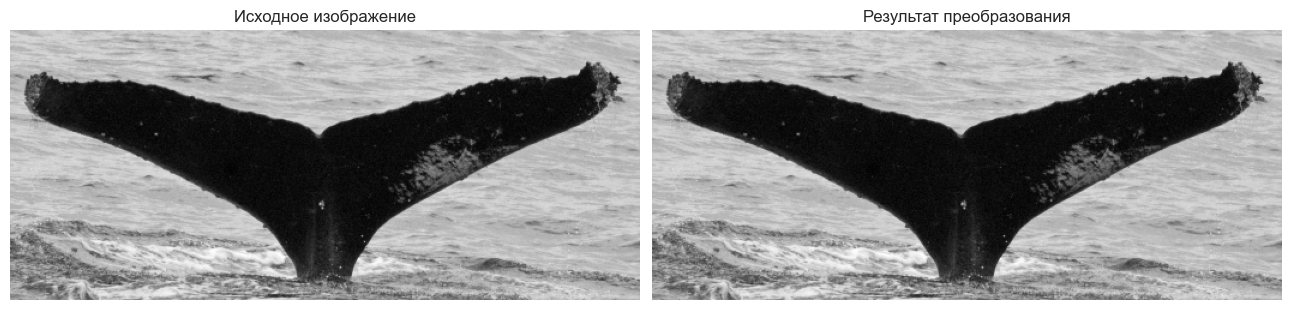

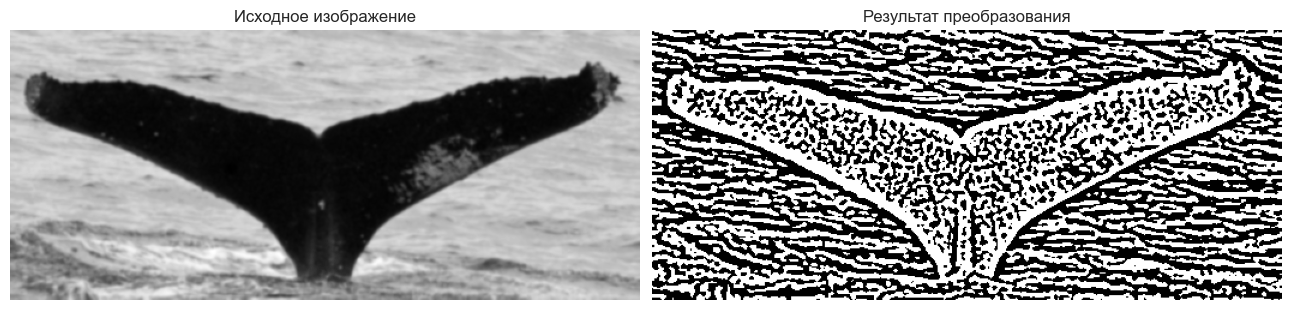

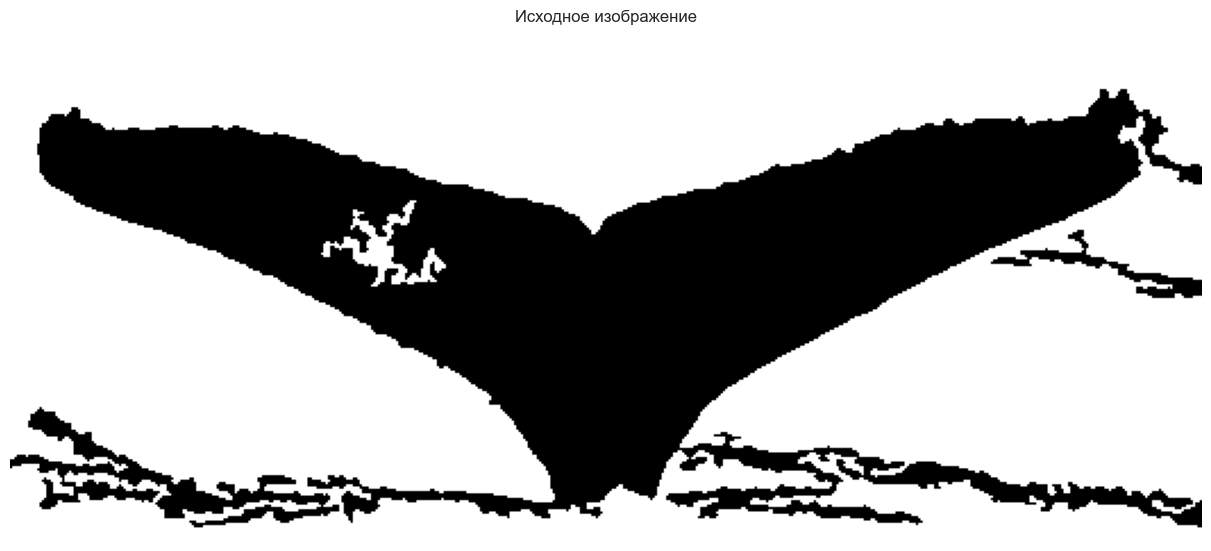

image 1


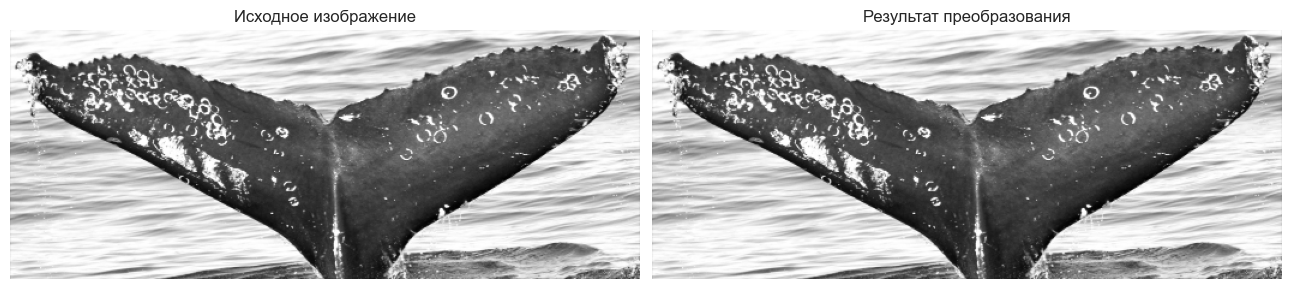

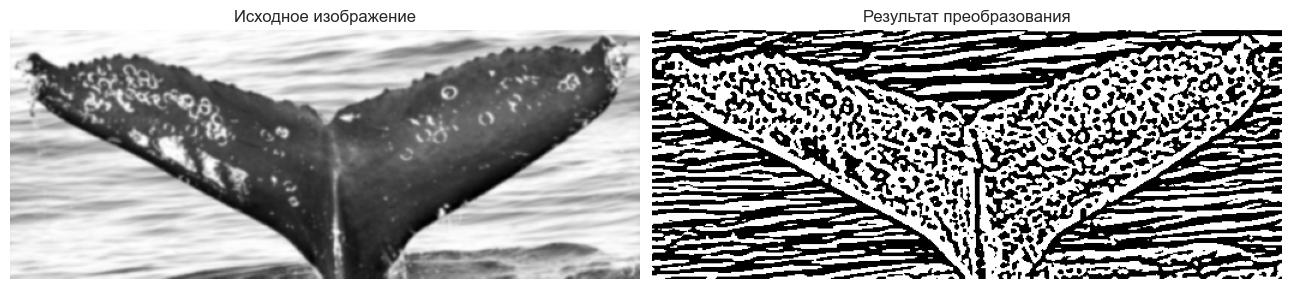

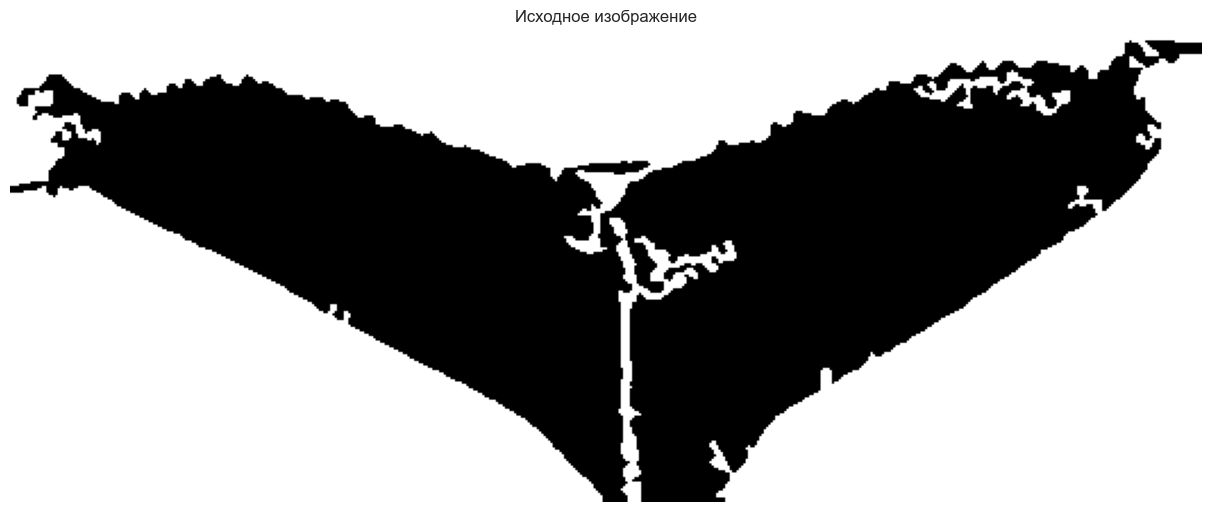

image 8


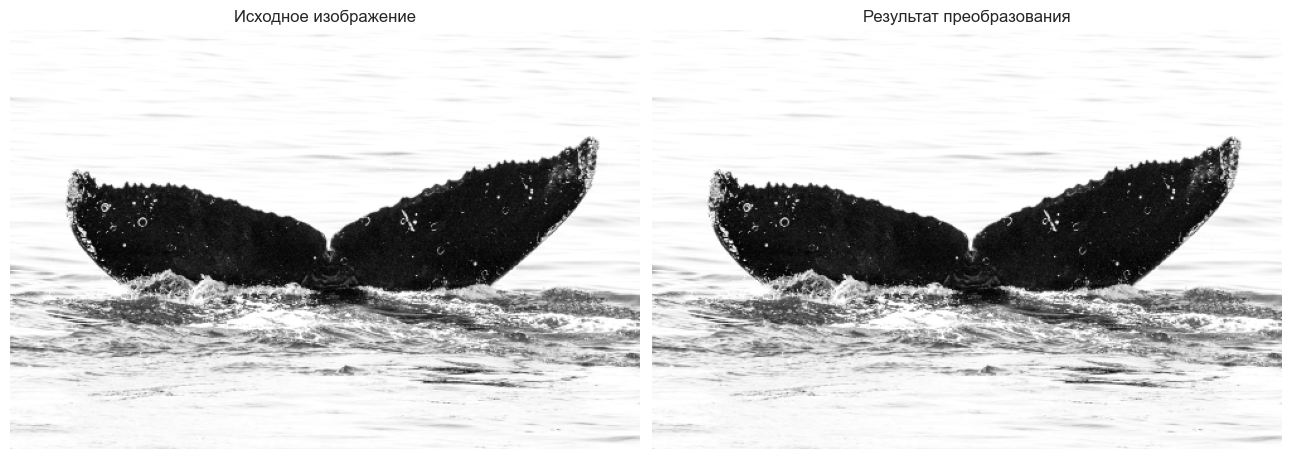

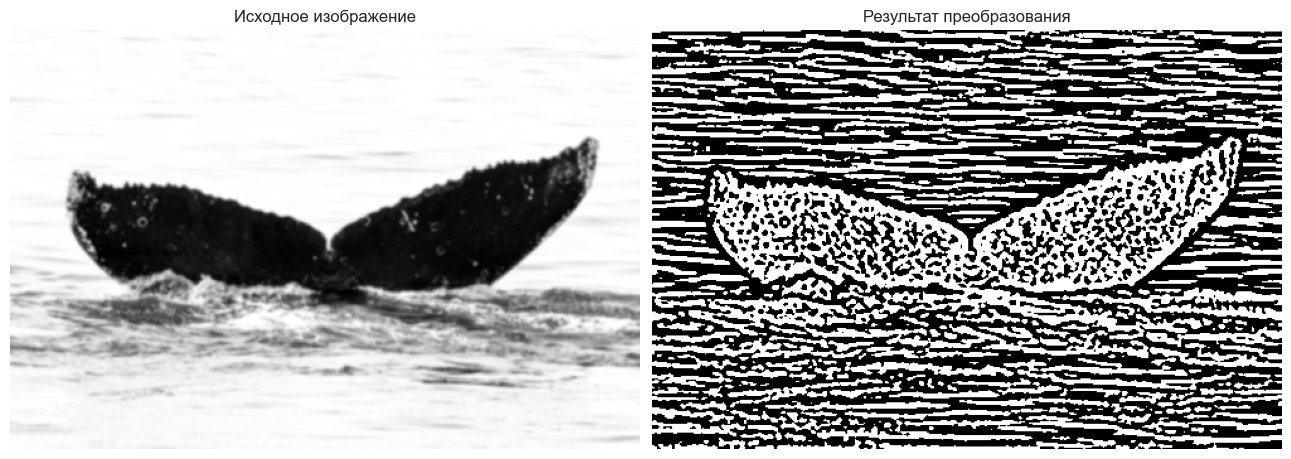

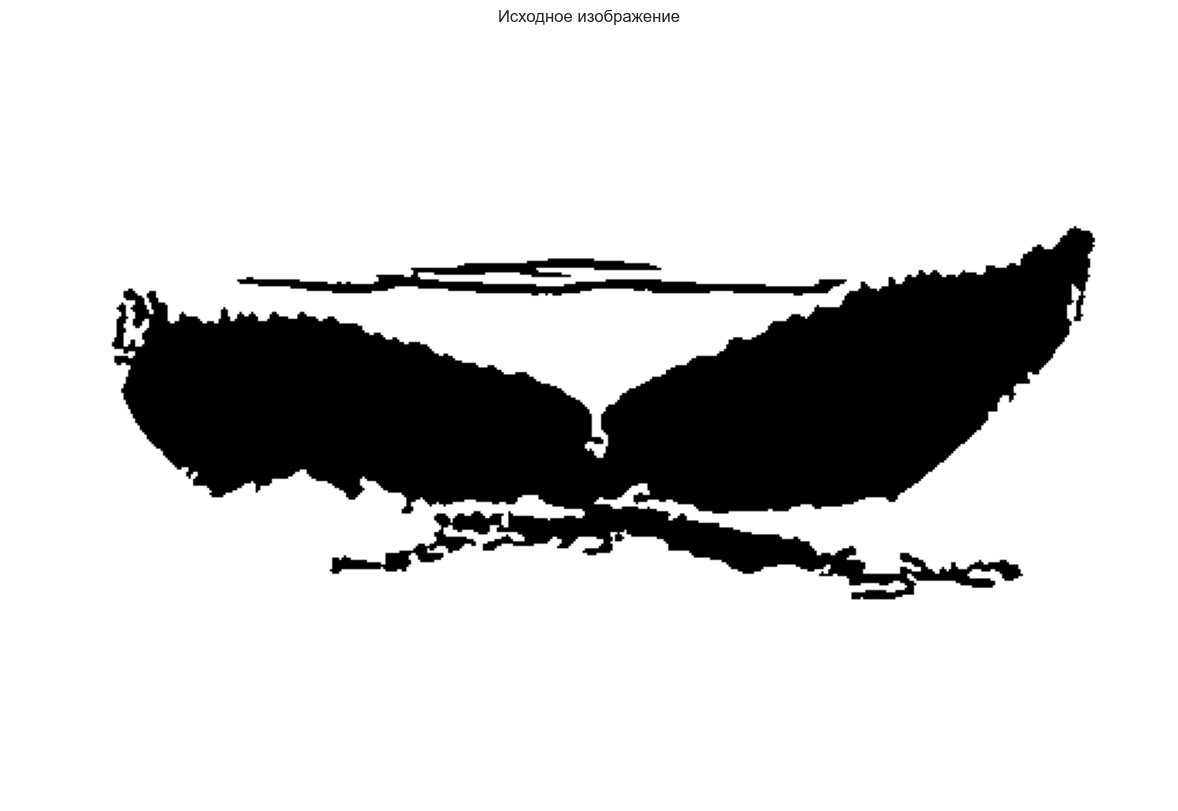

image 10


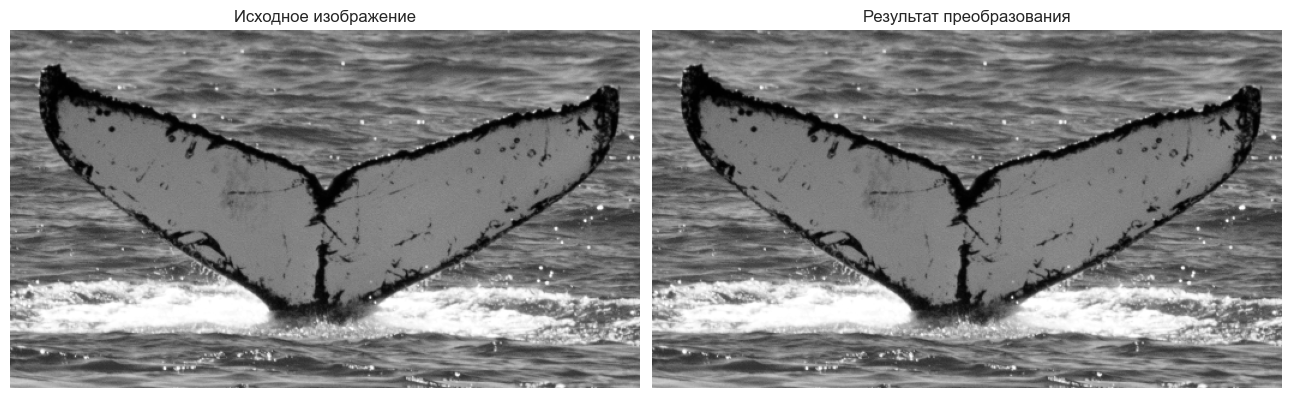

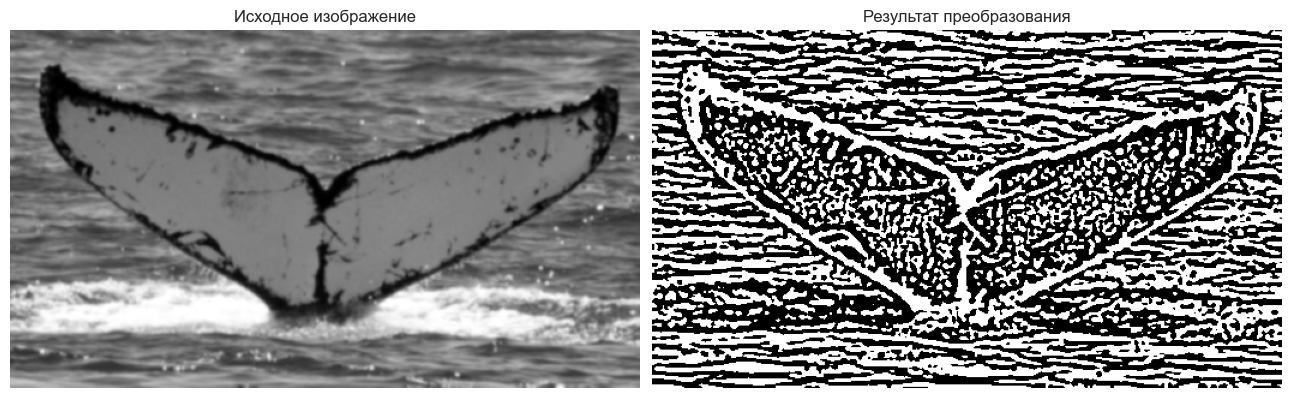

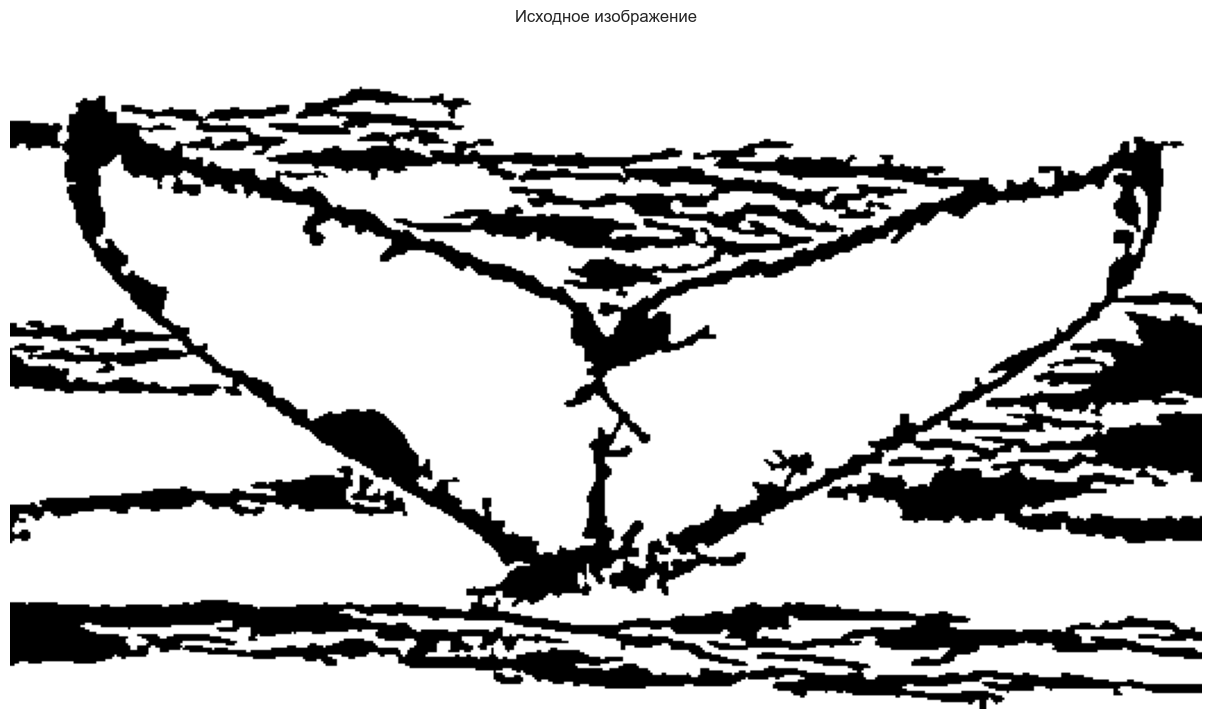

In [30]:
# go_i(-1)
go_i(0)
go_i(1)
go_i(8)
go_i(10)

In [27]:
def go(image):
    h, w, _ = image.shape
    image = cv2.resize(image.copy(), (w // 2, h // 2))
    image = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    # print(h, w)
    # grayscale
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)
    contours(image, 0.005, 9, 7)

In [28]:
def go_i(num=-1):
    if num == -1:
        for i in range(0, 10):
            if i == 4 or i == 5 or i == 9:
                continue
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_0{i}.jpg')
            go(image)
            print("----------------")
        for i in range(10, 12):
            print(f"image {i}")
            image = cv2.imread(f'whale_tail/test_image_{i}.jpg')
            go(image)
            print("----------------")
    else:
        print(f"image {num}")
        if num < 10:
            image = cv2.imread(f'whale_tail/test_image_0{num}.jpg')
        else:
            image = cv2.imread(f'whale_tail/test_image_{num}.jpg')
        go(image)